#### Following is to load spark module

In [1]:
import findspark
findspark.init()

### Analyze airline data with Spark SQL

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Analyze airline data") \
    .getOrCreate()

In [3]:
from pyspark.sql.types import Row
from datetime import datetime

#### Loading in airline data, for detailed explanation see pluralsight. ####### Spark2 by Janani Ravi. This has been modified  and is not exactly as in the course.

In [4]:
airlinesPath = "datasets/airlines.csv"
flightsPath = "datasets/flights.csv"

In [5]:
import os
print(os.environ.get('SPARK_HOME'))

C:\Users\padma\spark\spark-sql\tools\spark-3.1.2-bin-hadoop2.7


In [6]:
# pip install pandas
# format date
import pandas as pd

df = pd.DataFrame({"Date": ["26-12-2007", "27-12-2007", "28-12-2007"]})
df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')
type(df)

pandas.core.frame.DataFrame

In [7]:
print(df)

         Date
0  2007-12-26
1  2007-12-27
2  2007-12-28


In [8]:
# pyspark DataFrame
flights = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load(flightsPath)

In [9]:
type(flights)

pyspark.sql.dataframe.DataFrame

#### Convert spark dataframe to pandas dataframe. Note that the pandas and spark dataframe are not the same

In [10]:
# pandas DataFrame
df_pandas = flights.limit(10).toPandas()
df_pandas.style

,date,airlines,flight_number,origin,destination,departure,departure_delay,arrival,arrival_delay,air_time,distance
0,2014-04-01,19805,1,JFK,LAX,0854,-6.00,1217,2.00,355.00,2475.00
1,2014-04-01,19805,2,LAX,JFK,0944,14.00,1736,-29.00,269.00,2475.00
2,2014-04-01,19805,3,JFK,LAX,1224,-6.00,1614,39.00,371.00,2475.00
3,2014-04-01,19805,4,LAX,JFK,1240,25.00,2028,-27.00,264.00,2475.00
4,2014-04-01,19805,5,DFW,HNL,1300,-5.00,1650,15.00,510.00,3784.00
5,2014-04-01,19805,6,OGG,DFW,1901,126.00,0640,95.00,385.00,3711.00
6,2014-04-01,19805,7,DFW,OGG,1410,125.00,1743,138.00,497.00,3711.00
7,2014-04-01,19805,8,HNL,DFW,1659,4.00,0458,-22.00,398.00,3784.00
8,2014-04-01,19805,9,JFK,LAX,0648,-7.00,1029,19.00,365.00,2475.00
9,2014-04-01,19805,10,LAX,JFK,2156,21.00,0556,1.00,265.00,2475.00


In [11]:
# get datatype for data column
flights.select("date").dtypes


# pandas and spark dataframe's are not exacty the same
# Note that DataFrames are immutable, you can create new DataFrame but not modify.
import pyspark.sql.functions as F
# adding int_date column
flights= flights.withColumn("int_date", F.expr("replace(date, '-', '')"))
flights.select("int_date").dtypes

[('int_date', 'string')]

In [12]:
from pyspark.sql.types import IntegerType
flights = flights.withColumn("int_date",flights["int_date"].cast(IntegerType()))
flights.select("int_date").dtypes

[('int_date', 'int')]

In [13]:
flights.show(5)

+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|      date|airlines|flight_number|origin|destination|departure|departure_delay|arrival|arrival_delay|air_time|distance|int_date|
+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|2014-04-01|   19805|            1|   JFK|        LAX|     0854|          -6.00|   1217|         2.00|  355.00| 2475.00|20140401|
|2014-04-01|   19805|            2|   LAX|        JFK|     0944|          14.00|   1736|       -29.00|  269.00| 2475.00|20140401|
|2014-04-01|   19805|            3|   JFK|        LAX|     1224|          -6.00|   1614|        39.00|  371.00| 2475.00|20140401|
|2014-04-01|   19805|            4|   LAX|        JFK|     1240|          25.00|   2028|       -27.00|  264.00| 2475.00|20140401|
|2014-04-01|   19805|            5|   DFW|        HNL|     1300|          -5.00|   1650|  

#### Creating parquet file for flights

In [14]:
flights_19690_20304 = flights.filter(flights['airlines'].isin(["19690", "20304"])) 
flights_19690_20304 = flights_19690_20304.filter(flights_19690_20304['date'].isin(["2014-04-01", "2014-04-02"]))
flights_19690_20304.show()
#flights_19690_20304 = flights_19690_20304.drop("date")
#flights_19690_20304 = flights_19690_20304.withColumnRenamed("date1","date") 

flights_19690_20304.count()

+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|      date|airlines|flight_number|origin|destination|departure|departure_delay|arrival|arrival_delay|air_time|distance|int_date|
+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|2014-04-01|   19690|            1|   LAX|        HNL|     0834|          -6.00|   1204|        44.00|  360.00| 2556.00|20140401|
|2014-04-01|   19690|            2|   HNL|        LAX|     1342|          -3.00|   2151|       -19.00|  279.00| 2556.00|20140401|
|2014-04-01|   19690|            3|   LAX|        HNL|     0952|          -8.00|   1251|        21.00|  339.00| 2556.00|20140401|
|2014-04-01|   19690|            4|   HNL|        LAX|     2215|           0.00|   0615|       -20.00|  273.00| 2556.00|20140401|
|2014-04-01|   19690|            7|   LAS|        HNL|     0848|         -12.00|   1219|  

3591

In [15]:
flights_19690_20304.write.partitionBy("airlines","date","flight_number").mode("append").parquet("output/flights")

In [16]:
flights_19690_20304.printSchema()

root
 |-- date: string (nullable = true)
 |-- airlines: string (nullable = true)
 |-- flight_number: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- departure_delay: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- arrival_delay: string (nullable = true)
 |-- air_time: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- int_date: integer (nullable = true)



In [17]:
parqDF=spark.read.parquet("output/flights")
parqDF.createOrReplaceTempView("ParquetTable")
parkSQL = spark.sql("select * from ParquetTable where airlines = '19690' ")

In [18]:
type(parkSQL)

pyspark.sql.dataframe.DataFrame

In [19]:
# Collect the data to Python List
dataCollect = parkSQL.collect()
for row in dataCollect:
    print(row['origin'] + "," +row['destination'])

LAS,HNL
HNL,SMF
LAS,HNL
LAX,HNL
HNL,LAS
HNL,LAX
OAK,OGG
OGG,OAK
LAX,HNL
PHX,HNL
HNL,LAX
HNL,SAN
HNL,LAS
HNL,LAS
HNL,LAS
SJC,OGG
PDX,HNL
OAK,OGG
HNL,PHX
OAK,HNL
HNL,PHX
HNL,SFO
SMF,HNL
OGG,SJC
OAK,HNL
HNL,JFK
HNL,LAS
HNL,LAX
HNL,SFO
LAX,HNL
PDX,HNL
HNL,KOA
HNL,SMF
ITO,OGG
LAS,HNL
LAS,HNL
HNL,LIH
LAX,HNL
OGG,HNL
OGG,HNL
OGG,ITO
HNL,LIH
OGG,SJC
ITO,HNL
OGG,SEA
LIH,HNL
LIH,HNL
ITO,OGG
HNL,ITO
ITO,HNL
OGG,ITO
HNL,LIH
HNL,SEA
HNL,PDX
SFO,HNL
OGG,LIH
SEA,OGG
KOA,HNL
SAN,HNL
SJC,OGG
PHX,HNL
OGG,LIH
LIH,HNL
OGG,OAK
HNL,OGG
SEA,HNL
HNL,KOA
LAX,HNL
SFO,HNL
LAS,HNL
HNL,LAX
HNL,LAX
LAX,HNL
SEA,OGG
HNL,LAX
OGG,HNL
HNL,OGG
KOA,HNL
KOA,HNL
ITO,HNL
ITO,OGG
HNL,KOA
OGG,HNL
KOA,HNL
HNL,LIH
LIH,HNL
KOA,HNL
ITO,HNL
HNL,OGG
HNL,OGG
OGG,HNL
HNL,ITO
OGG,ITO
LIH,HNL
OGG,HNL
HNL,OGG
ITO,HNL
OGG,HNL
KOA,HNL
HNL,LIH
OGG,HNL
LIH,HNL
OGG,HNL
LIH,HNL
HNL,OGG
ITO,HNL
ITO,HNL
OGG,HNL
HNL,OGG
HNL,LIH
KOA,HNL
HNL,KOA
OGG,HNL
OGG,HNL
HNL,SEA
HNL,OAK
SMF,HNL
OGG,SEA
SAN,HNL
HNL,SAN
SEA,HNL
HNL,OAK
OGG,HNL
LIH,HNL
HNL,KOA


In [20]:
flights.count()
flights.show()

+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|      date|airlines|flight_number|origin|destination|departure|departure_delay|arrival|arrival_delay|air_time|distance|int_date|
+----------+--------+-------------+------+-----------+---------+---------------+-------+-------------+--------+--------+--------+
|2014-04-01|   19805|            1|   JFK|        LAX|     0854|          -6.00|   1217|         2.00|  355.00| 2475.00|20140401|
|2014-04-01|   19805|            2|   LAX|        JFK|     0944|          14.00|   1736|       -29.00|  269.00| 2475.00|20140401|
|2014-04-01|   19805|            3|   JFK|        LAX|     1224|          -6.00|   1614|        39.00|  371.00| 2475.00|20140401|
|2014-04-01|   19805|            4|   LAX|        JFK|     1240|          25.00|   2028|       -27.00|  264.00| 2475.00|20140401|
|2014-04-01|   19805|            5|   DFW|        HNL|     1300|          -5.00|   1650|  

## Create a flights table - sql table , The lifetime of this temporary table is tied  to the SparkSession

In [21]:
'''
createOrReplaceTempView creates (or replaces if that view name already exists) a lazily evaluated "view" 
that you can then use like a hive table in Spark SQL. It does not persist to memory unless you cache or persist the 
dataset that underpins the view.

# Add flights dataframe to the cluster catalog
'''
flights.createOrReplaceTempView("flights")
flights.columns

['date',
 'airlines',
 'flight_number',
 'origin',
 'destination',
 'departure',
 'departure_delay',
 'arrival',
 'arrival_delay',
 'air_time',
 'distance',
 'int_date']

### spark.catalog.listTables()
createOrReplaceTempView - method registers the DataFrame as a table in the catalog, but as this table is temporary, it can only be accessed from the specific SparkSession used to create the Spark DataFrame.
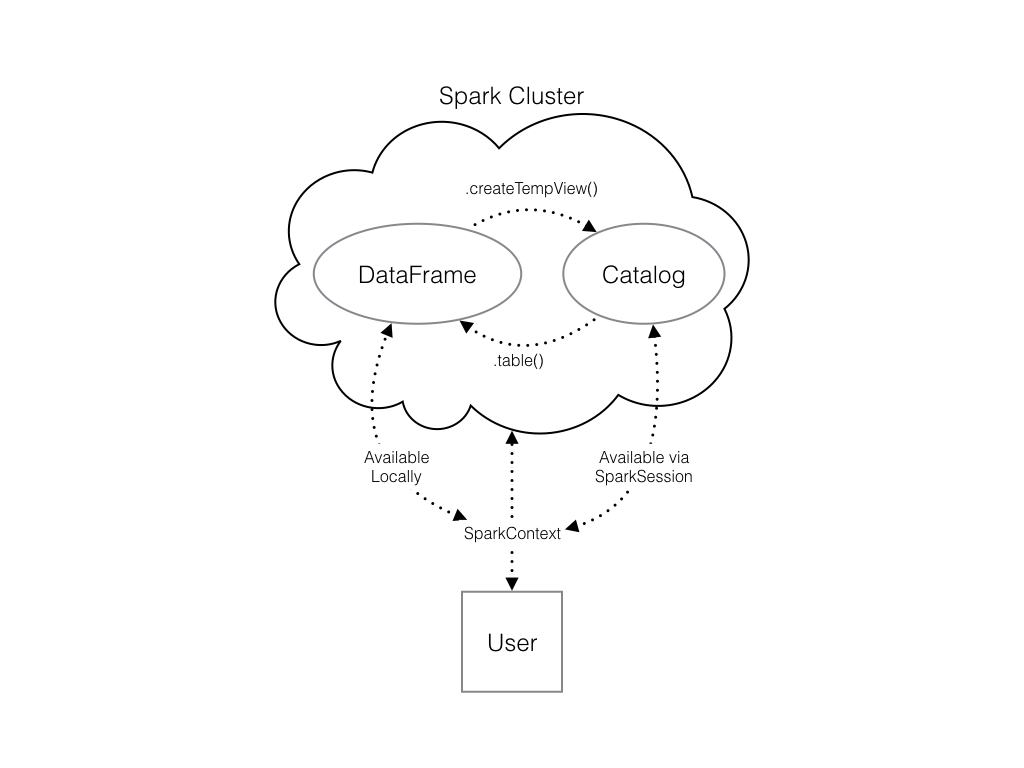

spark.catalog.listTables() -  returns the names of all the tables in your cluster as a list.
See what tables are in your cluster by calling spark.catalog.listTables()

In [22]:
spark.catalog.listTables()

[Table(name='flights', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='parquettable', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

#### Counting using SQL

In [33]:
flights_count = spark.sql("SELECT COUNT(*) FROM flights")

In [34]:
flights_count

DataFrame[count(1): bigint]

In [36]:
flights_count.collect()[0][0]

476881

#### Dataframes created using SQL commands can be aggregated, grouped etc. exactly as before

In [37]:
total_distance_df = spark.sql("SELECT distance FROM flights")\
                         .agg({"distance":"sum"})\
                         .withColumnRenamed("sum(distance)","total_distance")

# Caching
Spark will read the Parquet, csv, etc, execute the query only once and then cache it. Then the code in the loop will use the cached, pre-calculated DataFrame. Imagine that you are working with a lot of data, and you run a series of queries and actions on it without using caching. It runs again and again without you even noticing. This can add hours to the job running time or even make the job fail.

In [38]:
total_distance_df.cache()

DataFrame[total_distance: double]

In [41]:
total_distance_df.show()

+--------------+
|total_distance|
+--------------+
|  3.79052917E8|
+--------------+



# Explain Plan/Query Execution Plan
The best way to make sure everything has run as expected is to look at the execution plan.
You can see in the following execution plan the key words InMemoryTableScan and InMemoryRelation
which indicate that we are working on a cached DataFrame.

In [42]:
total_distance_df.explain()

== Physical Plan ==
*(1) ColumnarToRow
+- InMemoryTableScan [total_distance#486]
      +- InMemoryRelation [total_distance#486], StorageLevel(disk, memory, deserialized, 1 replicas)
            +- *(2) HashAggregate(keys=[], functions=[sum(cast(distance#26 as double))])
               +- Exchange SinglePartition, ENSURE_REQUIREMENTS, [id=#228]
                  +- *(1) HashAggregate(keys=[], functions=[partial_sum(cast(distance#26 as double))])
                     +- FileScan csv [distance#26] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/padma/github/sparksql-awsglue/aws-glue/datasets/flights.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<distance:string>




#### Analyzing flight delays

In [35]:
distinct_year = spark.sql(
    "SELECT distinct year(date) year  " +
    "FROM flights")
distinct_year.show()

+----+
|year|
+----+
|2014|
+----+

+----------+--------+-------------+---------------+
|      date|airlines|flight_number|departure_delay|
+----------+--------+-------------+---------------+
|2014-04-01|   19805|            1|          -6.00|
|2014-04-01|   19805|            2|          14.00|
|2014-04-01|   19805|            3|          -6.00|
|2014-04-01|   19805|            4|          25.00|
|2014-04-01|   19805|            5|          -5.00|
|2014-04-01|   19805|            6|         126.00|
|2014-04-01|   19805|            7|         125.00|
|2014-04-01|   19805|            8|           4.00|
|2014-04-01|   19805|            9|          -7.00|
|2014-04-01|   19805|           10|          21.00|
|2014-04-01|   19805|           12|          -2.00|
|2014-04-01|   19805|           14|           5.00|
|2014-04-01|   19805|           15|          -9.00|
|2014-04-01|   19805|           16|          17.00|
|2014-04-01|   19805|           17|          -5.00|
|2014-04-01|   19805|       

In [41]:
all_delays_2014 = spark.sql(
    "SELECT date, airlines, flight_number, departure_delay " +
    "FROM flights WHERE departure_delay > 0 and year(date) = 2014")

In [43]:
all_delays_2014.show(5)

+----------+--------+-------------+---------------+
|      date|airlines|flight_number|departure_delay|
+----------+--------+-------------+---------------+
|2014-04-01|   19805|            2|          14.00|
|2014-04-01|   19805|            4|          25.00|
|2014-04-01|   19805|            6|         126.00|
|2014-04-01|   19805|            7|         125.00|
|2014-04-01|   19805|            8|           4.00|
+----------+--------+-------------+---------------+
only showing top 5 rows



In [45]:
all_delays_2014.orderBy(all_delays_2014.departure_delay.desc()).show(5)

+----------+--------+-------------+---------------+
|      date|airlines|flight_number|departure_delay|
+----------+--------+-------------+---------------+
|2014-04-27|   20366|         5246|          99.00|
|2014-04-27|   19393|         2948|          99.00|
|2014-04-27|   20366|         5365|          99.00|
|2014-04-26|   19977|          616|          99.00|
|2014-04-27|   20366|         6030|          99.00|
+----------+--------+-------------+---------------+
only showing top 5 rows



#### Total number of delayed flights in 2014

In [51]:
all_delays_2014.createOrReplaceTempView("all_delays_2014")

In [52]:
delay_count = spark.sql("SELECT COUNT(departure_delay) FROM all_delays_2014")

In [53]:
delay_count.show()

+----------------------+
|count(departure_delay)|
+----------------------+
|                179015|
+----------------------+



In [54]:
delay_count.collect()[0][0]

179015

#### Percentage of flights delayed

In [55]:
delay_percent = delay_count.collect()[0][0] / flights_count.collect()[0][0] * 100
delay_percent

37.53871510922012

### Finding delay per aIrlines

In [63]:
airlines = spark.read\
                .format("csv")\
                .option("header", "true")\
                .load(airlinesPath)
airlines.createOrReplaceTempView("airlines")
airlines = spark.sql("SELECT * FROM airlines")
airlines.columns

['Code', 'Description']

In [64]:
delay_per_airline = spark.sql("SELECT airlines, departure_delay FROM flights")\
                         .groupBy("airlines")\
                         .agg({"departure_delay":"avg"})\
                         .withColumnRenamed("avg(departure_delay)", "departure_delay")

In [65]:
delay_per_airline.orderBy(delay_per_airline.departure_delay.desc()).show(5)

+--------+------------------+
|airlines|   departure_delay|
+--------+------------------+
|   19393|13.429567657134724|
|   20366|12.296210112379818|
|   19977| 8.818392620527979|
|   20436| 8.716275167785234|
|   20409|  8.31110357194785|
+--------+------------------+
only showing top 5 rows



In [66]:
delay_per_airline.createOrReplaceTempView("delay_per_airline")

In [67]:
delay_per_airline = spark.sql("SELECT * FROM delay_per_airline ORDER BY departure_delay DESC")

In [68]:
delay_per_airline.show(5)

+--------+------------------+
|airlines|   departure_delay|
+--------+------------------+
|   19393|13.429567657134724|
|   20366|12.296210112379818|
|   19977| 8.818392620527979|
|   20436| 8.716275167785234|
|   20409|  8.31110357194785|
+--------+------------------+
only showing top 5 rows



#### SQL join operations 

* Get the names of the delayed flights

In [69]:
delay_per_airline = spark.sql("SELECT * FROM delay_per_airline " +
                              "JOIN airlines ON airlines.code = delay_per_airline.airlines " +
                              "ORDER BY departure_delay DESC")

delay_per_airline.show(5)

+--------+------------------+-----+--------------------+
|airlines|   departure_delay| Code|         Description|
+--------+------------------+-----+--------------------+
|   19393|13.429567657134724|19393|Southwest Airline...|
|   20366|12.296210112379818|20366|ExpressJet Airlin...|
|   19977| 8.818392620527979|19977|United Air Lines ...|
|   20436| 8.716275167785234|20436|Frontier Airlines...|
|   20409|  8.31110357194785|20409| JetBlue Airways: B6|
+--------+------------------+-----+--------------------+
only showing top 5 rows



In [70]:
delay_per_airline.drop("code").show(5)

+--------+------------------+--------------------+
|airlines|   departure_delay|         Description|
+--------+------------------+--------------------+
|   19393|13.429567657134724|Southwest Airline...|
|   20366|12.296210112379818|ExpressJet Airlin...|
|   19977| 8.818392620527979|United Air Lines ...|
|   20436| 8.716275167785234|Frontier Airlines...|
|   20409|  8.31110357194785| JetBlue Airways: B6|
+--------+------------------+--------------------+
only showing top 5 rows

